# Antidiabetic drug prescriptions in Australia

The objective of the project: <br>
* To forecast the next 12 months of antidiabetic drug prescriptions using the number of antidiabetic drug prescription data in Australia, from 1991 to 2008.

>from [Time series forecasting in Python by Marco Peixeiro](https://github.com/marcopeix/TimeSeriesForecastingInPython)

In [28]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import  STL
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from tqdm.notebook import tqdm
from itertools import product
from typing import Union

import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['text.color'] = 'k'

In [20]:
df = pd.read_csv('./data/AusAntidiabeticDrug.csv')
df.head()

,ds,y
0,1991-07-01,3.526591
1,1991-08-01,3.180891
2,1991-09-01,3.252221
3,1991-10-01,3.611003
4,1991-11-01,3.565869


In [21]:
df.loc[:,'ds']= pd.to_datetime(df['ds'], format='%Y-%m-%d')
df= df.set_index('ds')
df.index.name = 'date'
df=df.rename(columns={'y':'#prescriptions'})
df.head()

,#prescriptions
date,
1991-07-01,3.526591
1991-08-01,3.180891
1991-09-01,3.252221
1991-10-01,3.611003
1991-11-01,3.565869


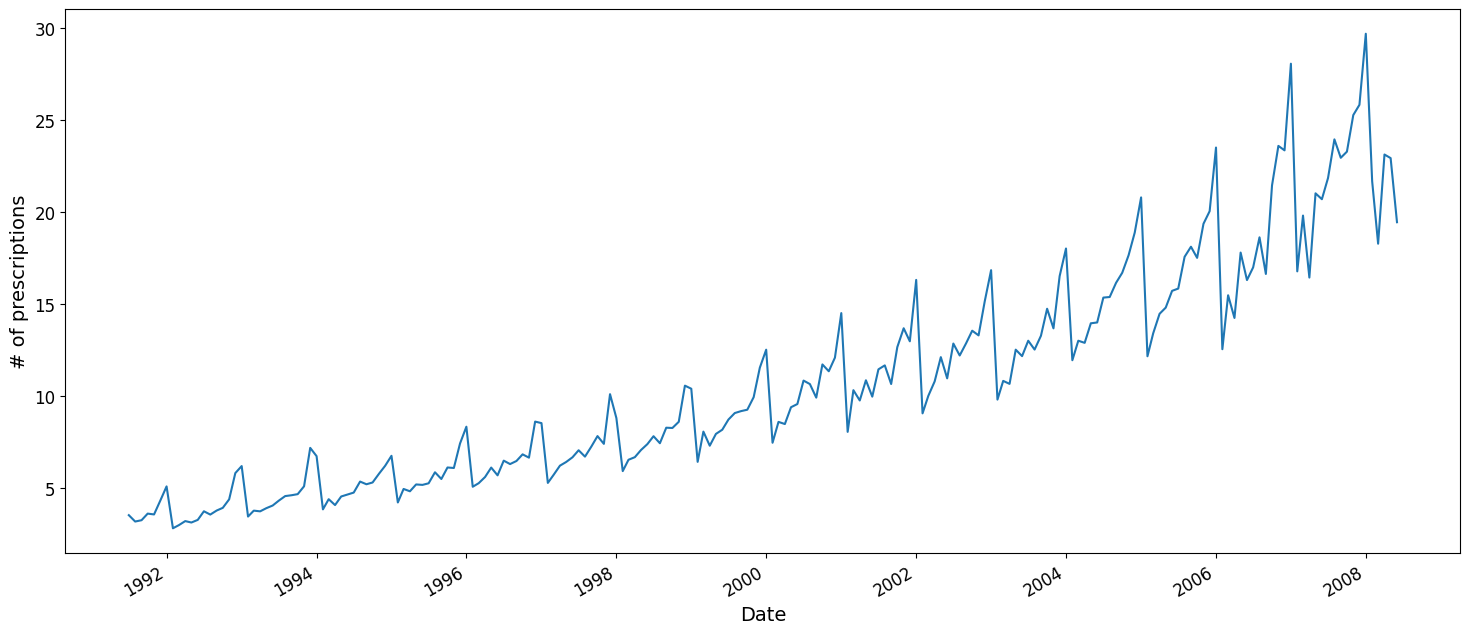

In [45]:
fig, ax = plt.subplots()

ax.plot(df.index, df['#prescriptions'])
ax.set_xlabel('Date')
ax.set_ylabel('# of prescriptions')
fig.autofmt_xdate()

Based on the plot, it is obvous that the time series is non-stationary. But let's run the ADF test whether it is non-stationary or not.

## Decomposition

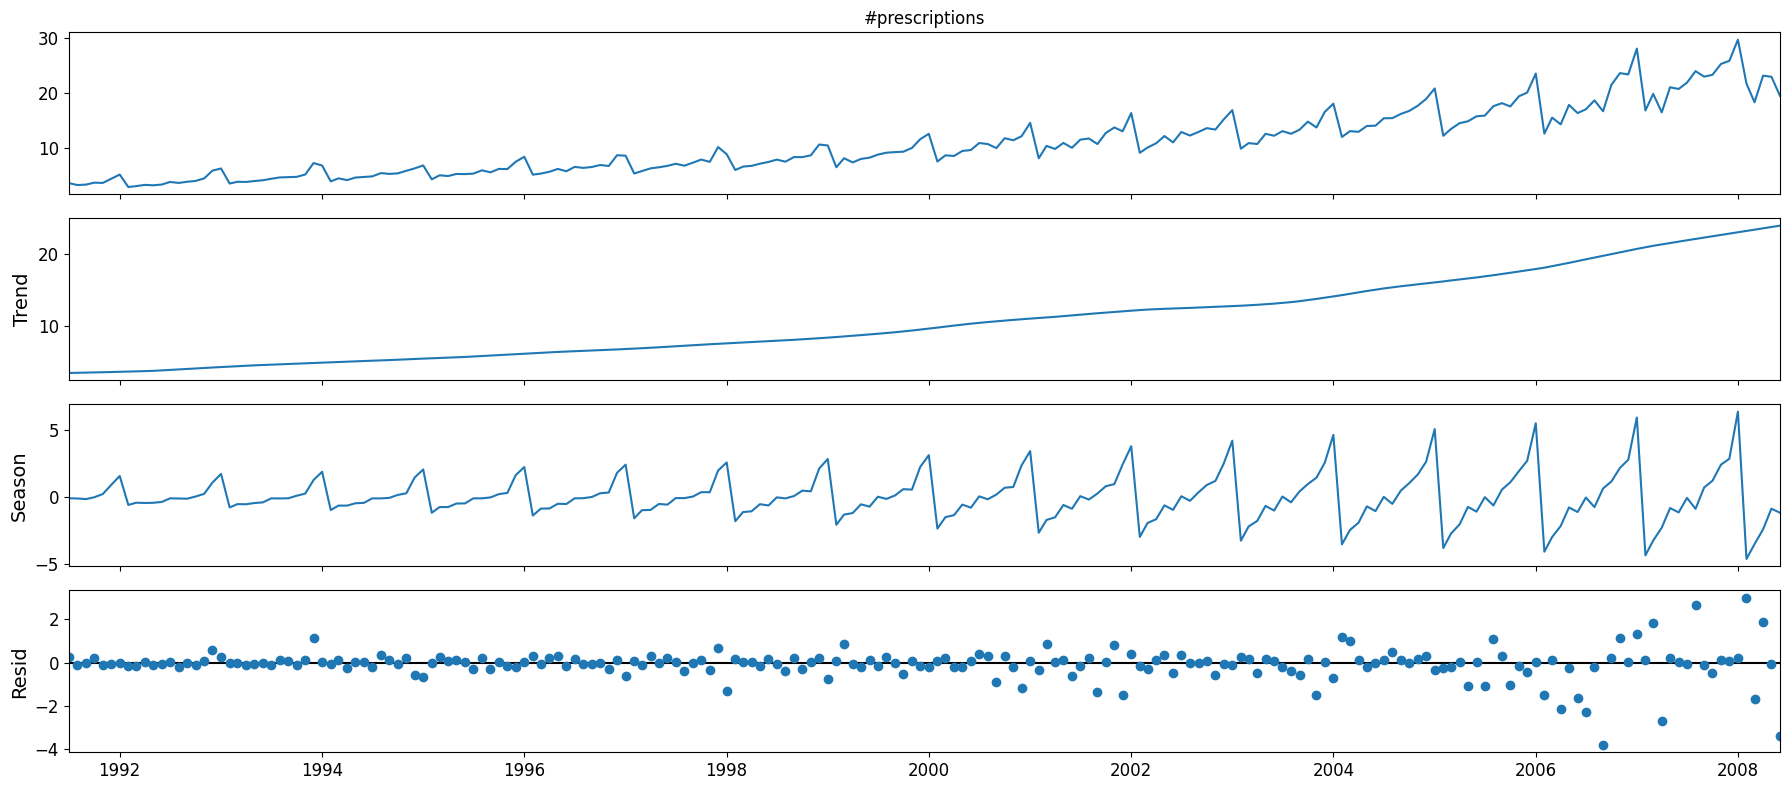

In [ ]:
# stl decomposition
stl = STL(df['#prescriptions'], seasonal=13, robust=True)
stl_series = stl.fit()
# Plot the decomposition components
stl_series.plot()
plt.show()

The time series has trend and seasonal componenets

## ADF test

In [42]:
def performe_adf_test(series: pd.Series) -> None:
    ADF_result = adfuller(series)
    print(f'ADF Statistic: {ADF_result[0]}')
    print(f'p-value: {ADF_result[1]}')

In [38]:
performe_adf_test(df['#prescriptions'])

ADF Statistic: 3.145185689306737
p-value: 1.0


The ADF test fails to reject the null hypothesis that a time series is non-stationary.

## ACF and PACF plot

In [43]:
def plot_acf_pacf(series: pd.Series):
    plot_acf(series, lags=30);
    plot_pacf(series, lags=30);

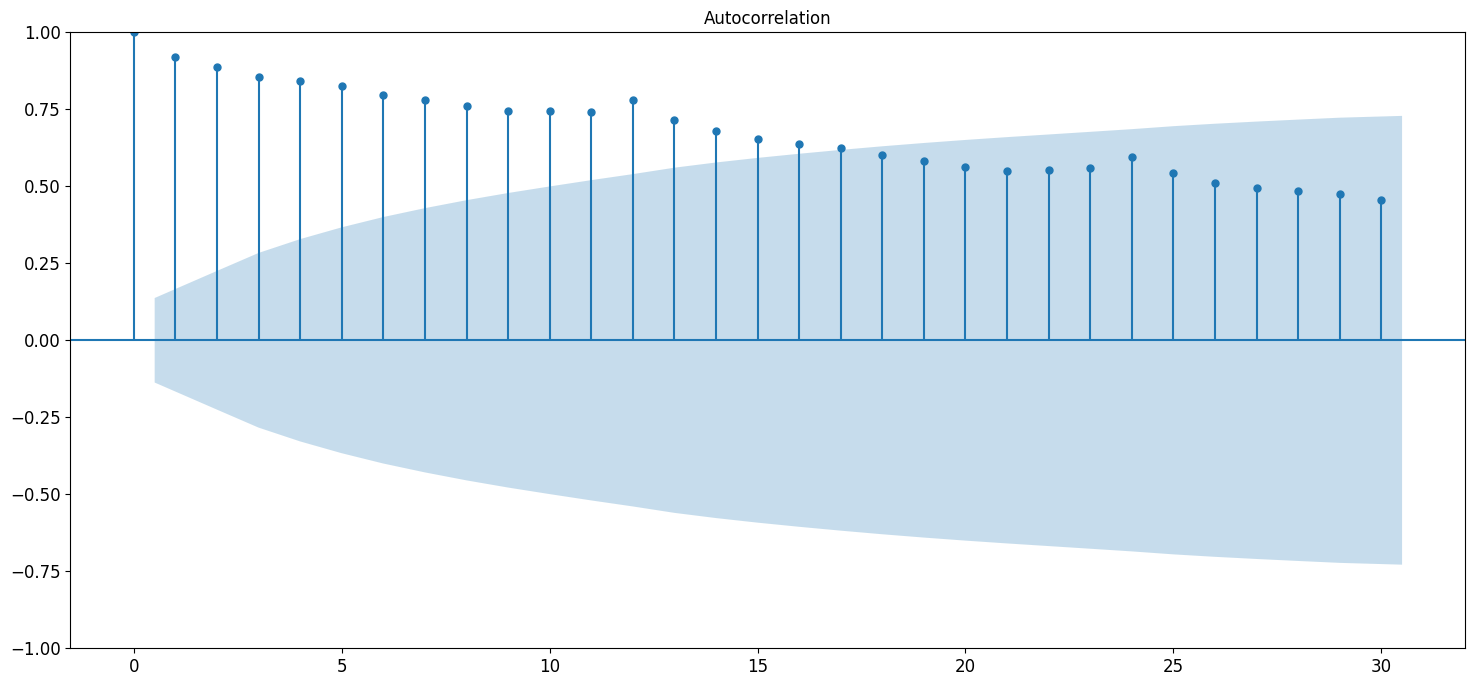

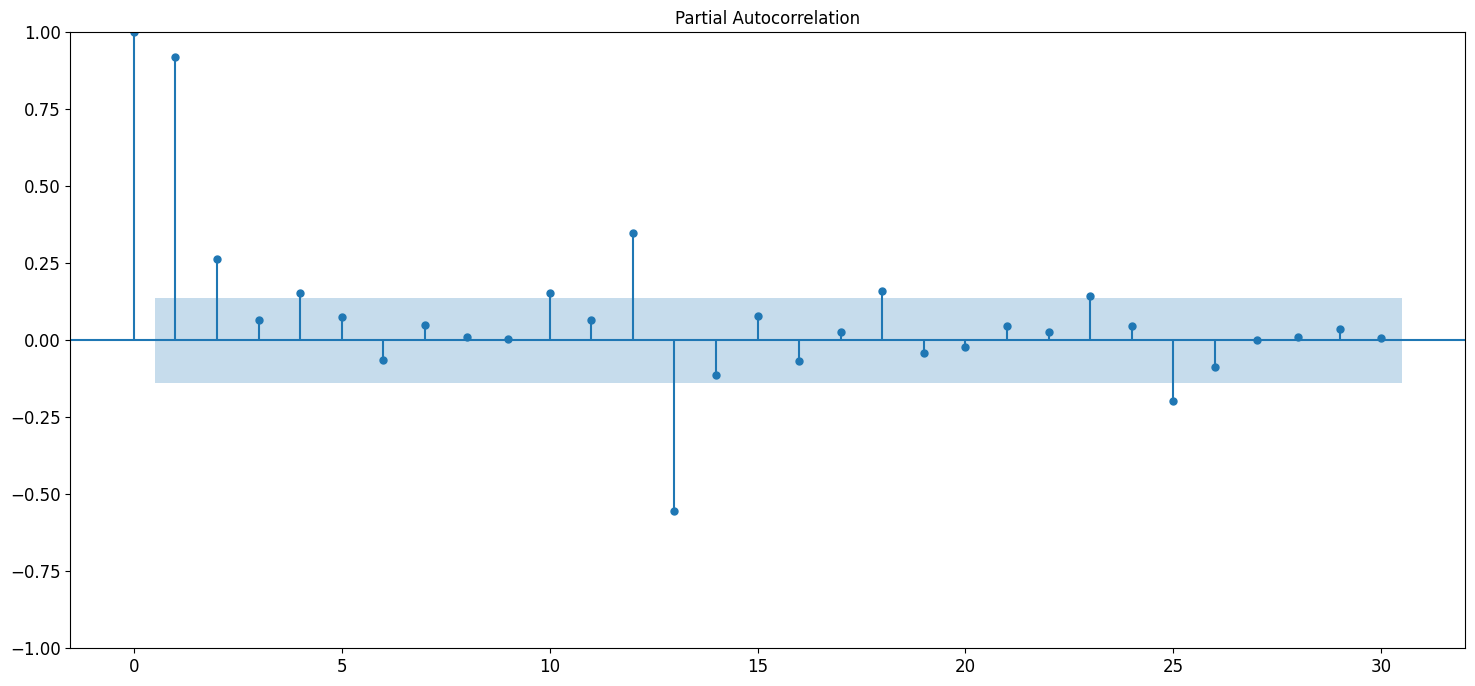

In [40]:
plot_acf_pacf(df['#prescriptions'])

## Differencing

In [41]:
df_diff = np.diff(df['#prescriptions'], n=1)
performe_adf_test(df_diff)

ADF Statistic: -2.495172147449698
p-value: 0.11665341686469793


The time seris is still non-stationary. Apply seasonal differencing

In [49]:
df_diff_seasonal_diff = np.diff(df_diff, n=12)
performe_adf_test(df_diff_seasonal_diff)

ADF Statistic: -19.84844009696188
p-value: 0.0


The series is now stationary. 
* d = 1,
* D = 1

## Optimize SARIMA parameters

In [52]:
def optimize_SARIMA(endog: Union[pd.Series, list], order_list: list, d: int, D: int, s: int) -> pd.DataFrame:

    results = []

    for order in tqdm(order_list):
        try:
            model = SARIMAX(
                endog,
                order=(order[0], d, order[1]),
                seasonal_order=(order[2], D, order[3], s),
                simple_differencing=False).fit(disp=False)
        except:
            continue

        aic = model.aic
        results.append([order, aic])

    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q,P,Q)', 'AIC']

    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)

    return result_df

In [79]:
SIZE = 36
train = df[:-SIZE]
test = df[-SIZE:]

In [80]:
ps = range(0, 4, 1)
qs = range(0, 4, 1)
Ps = range(0, 4, 1)
Qs = range(0, 4, 1)

SARIMA_order_list = list(product(ps, qs, Ps, Qs))

d = 1
D = 1
s = 12   # monthly data, so 12 data points per seasonal cycle

SARIMA_result_df = optimize_SARIMA(train['#prescriptions'], SARIMA_order_list, d, D, s)
SARIMA_result_df

  0%|          | 0/256 [00:00<?, ?it/s]

,"(p,q,P,Q)",AIC
0,"(3, 1, 1, 3)",270.951097
1,"(3, 3, 1, 3)",271.401591
2,"(3, 2, 1, 3)",272.222636
3,"(3, 3, 0, 1)",272.580413
4,"(3, 3, 2, 0)",272.949439
...,...,...
251,"(0, 0, 3, 1)",351.425175
252,"(0, 0, 1, 1)",351.466837
253,"(0, 0, 0, 1)",354.751719
254,"(0, 0, 1, 0)",357.173706


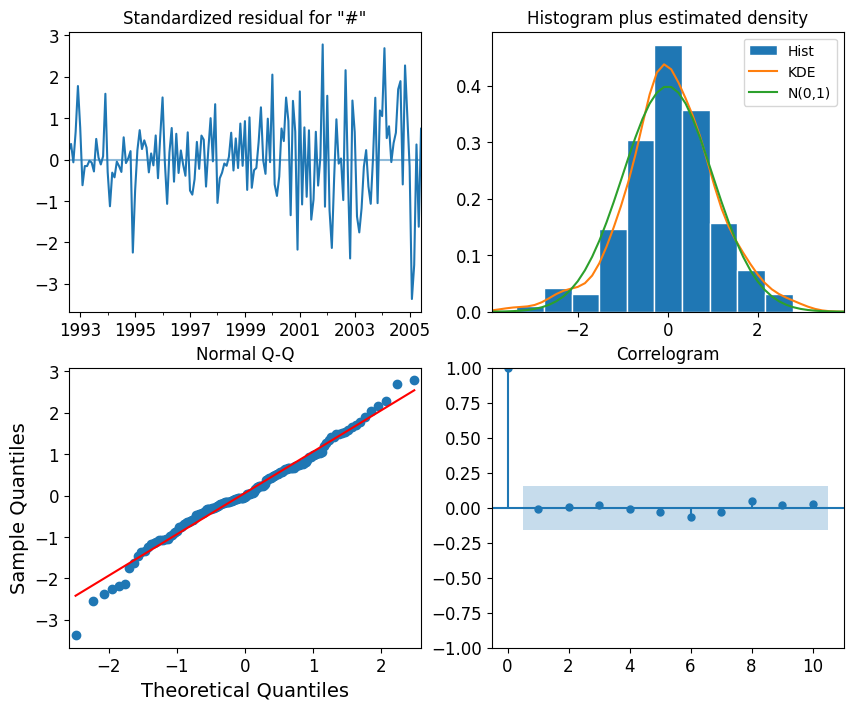

In [81]:
SARIMA_model = SARIMAX(train,
                       order=[3,1,3],
                       seasonal_order=[1,1,3,12],
                       simple_differencing=False
                       )
SARIMA_model_fit = SARIMA_model.fit(disp=0)
SARIMA_model_fit.plot_diagnostics(figsize=(10,8));

In [82]:
residuals = SARIMA_model_fit.resid
acorr_ljungbox(residuals, np.arange(1,11,1))

,lb_stat,lb_pvalue
1,0.530487,0.466402
2,0.687725,0.709026
3,1.016950,0.797151
4,1.264041,0.867446
5,1.560481,0.905987
6,1.607245,0.952055
7,6.186376,0.518164
8,6.628587,0.577183
9,6.650772,0.673427
10,6.750825,0.748741


## Forecasting

In [86]:
def rolling_forecast(df: pd.DataFrame, train_len: int, horizon: int, window: int, method: str) -> list:

    total_len = train_len + horizon
    end_idx = train_len

    if method == 'last_season':
        pred_last_season = []

        for i in range(train_len, total_len, window):
            last_season = df['#prescriptions'][i-window:i].values
            pred_last_season.extend(last_season)

        return pred_last_season

    elif method == 'SARIMA':
        pred_SARIMA = []

        for i in range(train_len, total_len, window):
            model = SARIMAX(df['#prescriptions'][:i], order=(3,1,3), seasonal_order=(1,1,3,12), simple_differencing=False)
            res = model.fit(disp=False)
            predictions = res.get_prediction(0, i + window - 1)
            oos_pred = predictions.predicted_mean.iloc[-window:]
            pred_SARIMA.extend(oos_pred)

        return pred_SARIMA

In [87]:
TRAIN_LEN = 168
HORIZON = 36
WINDOW = 12

test['last_season'] = rolling_forecast(df, TRAIN_LEN, HORIZON, WINDOW, 'last_season')
test['SARIMA'] = rolling_forecast(df, TRAIN_LEN, HORIZON, WINDOW, 'SARIMA')

test.head()

,#prescriptions,last_season,SARIMA
date,,,
2005-07-01,15.829550,15.339097,16.714750
2005-08-01,17.554701,15.370764,16.522417
2005-09-01,18.100864,16.142005,17.233286
2005-10-01,17.496668,16.685754,18.101985
2005-11-01,19.347265,17.636728,18.468304


In [108]:
boundary_start = test.index[0]
boundary_end = test.index[-1]
first_record = df.index[0]
last_record = df.index[-1]

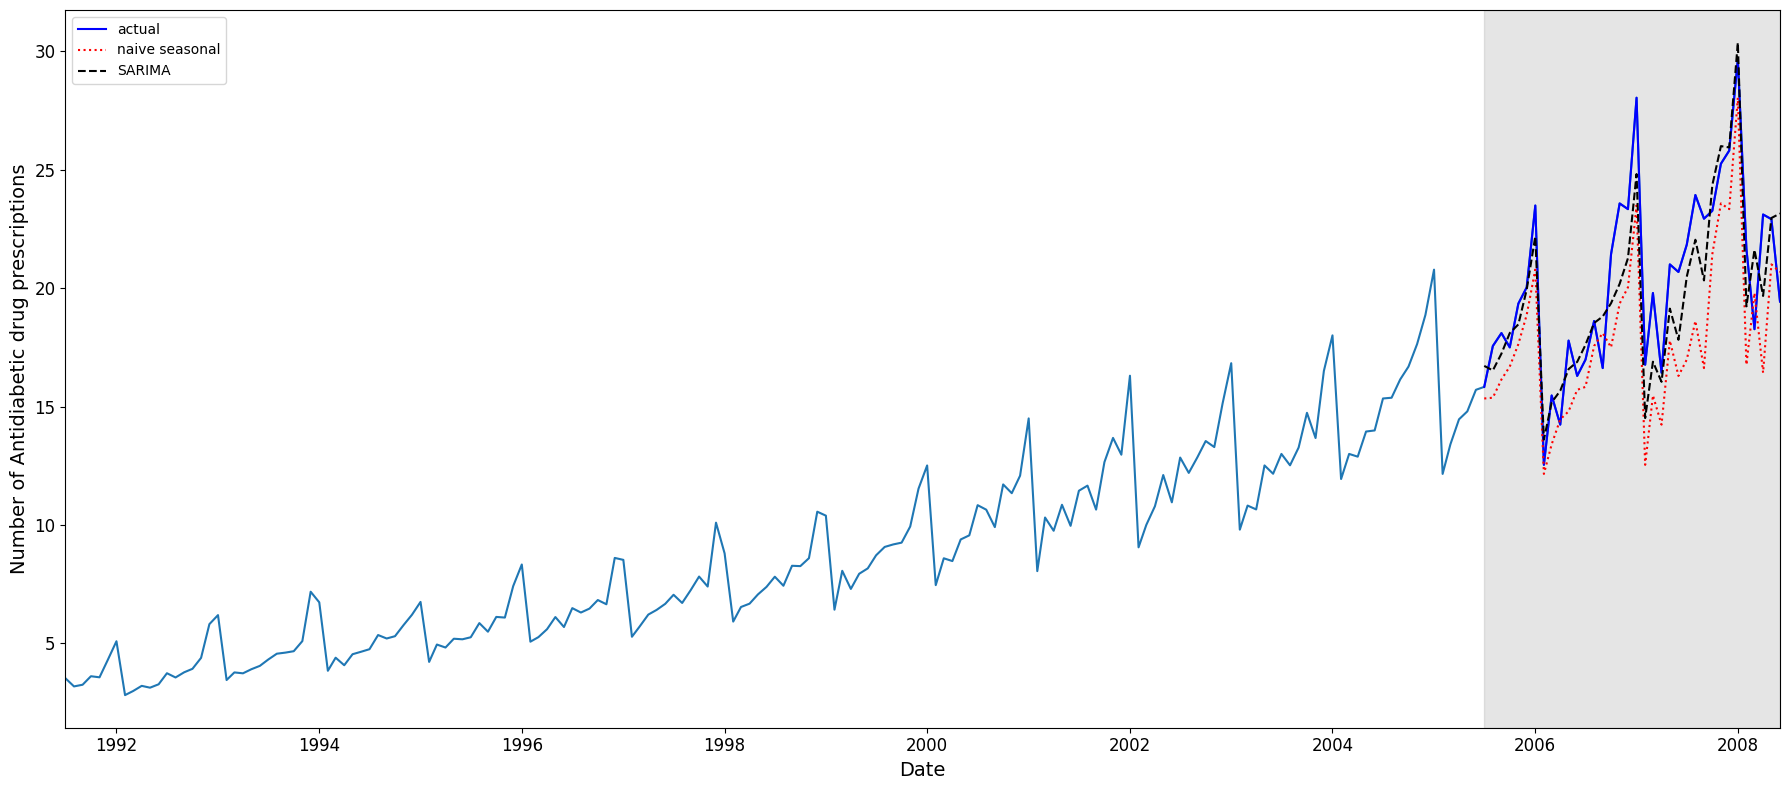

In [109]:
fx, ax = plt.subplots()
ax.plot(df['#prescriptions'])
ax.plot(test['#prescriptions'], 'b-',label='actual')
ax.plot(test['last_season'], 'r:',label='naive seasonal')
ax.plot(test['SARIMA'], 'k--', label='SARIMA')
ax.set_xlabel('Date')
ax.set_ylabel('Number of Antidiabetic drug prescriptions')
ax.axvspan(boundary_start,boundary_end, color='#808080', alpha=0.2)
ax.legend(loc=2)

# plt.xticks(np.arange(6,203,12), np.arange(1992,2009, 1))
plt.xlim(first_record,last_record)

fig.autofmt_xdate()
plt.tight_layout()

## Model Evaluation

In [110]:
def mape(y_true, y_pred):
 return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [114]:
mape_naive_seasonal = mape(test['#prescriptions'], test['last_season'])
mape_SARIMA = mape(test['#prescriptions'], test['SARIMA'])

print(f'MPAE naive seasonal: {mape_naive_seasonal}\nMAPE SARIMA model: {mape_SARIMA}')

MPAE naive seasonal: 12.686561923100614
MAPE SARIMA model: 7.65866173672284


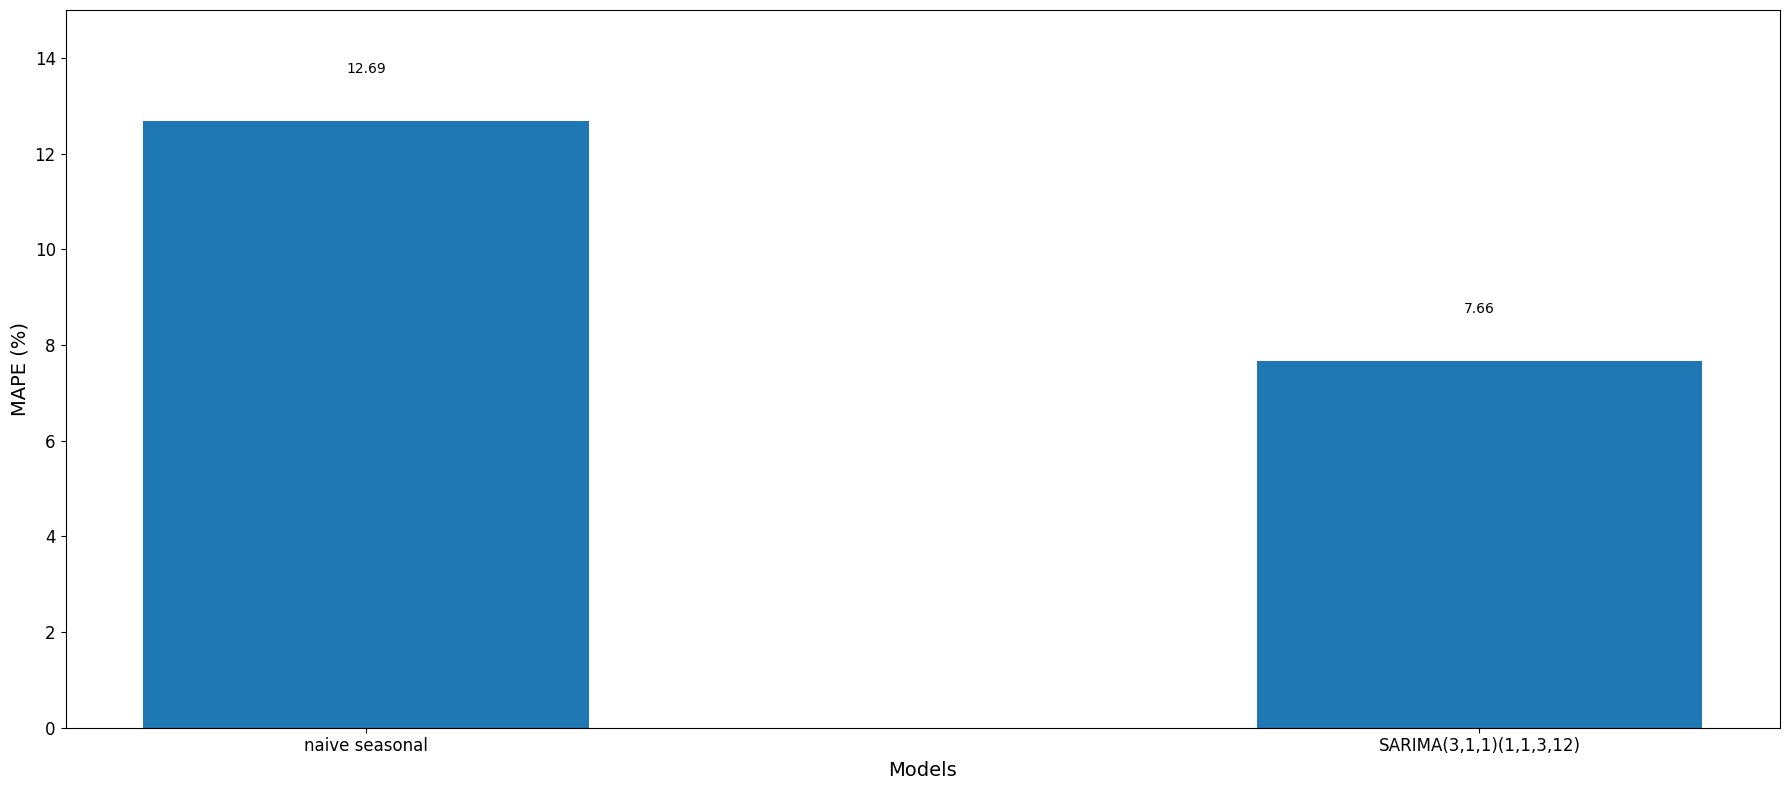

In [116]:
fig, ax = plt.subplots()

x = ['naive seasonal', 'SARIMA(3,1,1)(1,1,3,12)']
y = [mape_naive_seasonal, mape_SARIMA]

ax.bar(x, y, width=0.4)
ax.set_xlabel('Models')
ax.set_ylabel('MAPE (%)')
ax.set_ylim(0, 15)

for index, value in enumerate(y):
    plt.text(x=index, y=value + 1, s=str(round(value,2)), ha='center')

plt.tight_layout()